Authorization

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Libraries

In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import pearsonr


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Helper Functions

In [0]:
# Correlation every week
def corr_week(weeks,df_metric,df_outcome,left_on,right_on,directory_out):
    for w in weeks:
        df_metric_temp = df_metric.loc[df_metric['week']==w]
        df_metric_temp.sort_values(by=right_on,inplace=True)
        df_metric_temp.reset_index(inplace=True,drop=True)

        df_outcome_temp = df_outcome.loc[df_outcome['week']==w]
        df_outcome_temp.sort_values(by=left_on,inplace=True)
        df_outcome_temp.reset_index(inplace=True,drop=True)

        df_corr = df_outcome_temp.merge(df_metric_temp, left_on=left_on, right_on=right_on)
        drop = list(set(left_on + right_on))
        df_corr = df_corr.drop(drop,axis=1)
        df_corr.dropna(axis=1,how="all",inplace=True)
        df_corr.dropna(axis=0,how="any",inplace=True)
        df_coeff = pd.DataFrame(index=df_corr.columns, columns=df_corr.columns)
        df_pvalue = pd.DataFrame(index=df_corr.columns, columns=df_corr.columns)

        for i in df_corr.columns:    
            for j in df_corr.columns:        
                corrtest = pearsonr(df_corr[i], df_corr[j])  
                df_coeff.loc[i,j] = corrtest[0]
                df_pvalue.loc[i,j] = corrtest[1] 

        df_coeff.to_csv('{}/df_coeff_{}.csv'.format(directory_out,w))
        df_pvalue.to_csv('{}/df_pvalue_{}.csv'.format(directory_out,w))


In [0]:
# Determine Signficant Correlations

def sign_corr(alphas,weeks,outcome,directory_out):
    for a in alphas:
        df_significant = pd.DataFrame(columns=['week','metric','outcome','correlation','pvalue'])
        for w in weeks:
            df_coeff = pd.read_csv('{}/df_coeff_{}.csv'.format(directory_out,w),index_col=0)
            df_pvalue = pd.read_csv('{}/df_pvalue_{}.csv'.format(directory_out,w),index_col=0)
            metric = list(df_pvalue.columns)
            if df_pvalue.empty == True:
                print(w)
            else:
                for i in outcome:
                    metric.remove(i)
                for i in metric:    
                    for j in outcome:        
                        if i <= j:
                            continue
                        elif df_pvalue.loc[i,j] < a: 
                            df_significant = df_significant.append({'week':w,'metric':i,'outcome':j,
                                                                   'correlation':df_coeff.loc[i,j],'pvalue':df_pvalue.loc[i,j]}
                                                                   ,ignore_index=True)

        df_significant.to_csv('{}/df_significant_{}.csv'.format(directory_out,a))

Data Preparations

In [0]:
# read df_metric
file_in = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Processed Data/df_weekly.csv'
df_metric = pd.read_csv(file_in,index_col=0)

In [0]:
# reduce to three types (individual, students, instructors)

old_types = ['Individual', 'Instructor', 'Instructors', 'Mixed', 'Student', 'Students']
new_types = ['Individual', 'Instructors', 'Instructors', 'Instructors', 'Students', 'Students']

type_dict = dict(zip(old_types, new_types))
df_metric['type'] = df_metric['type'].map(type_dict)

df_metric = df_metric.groupby(['name','identity','week','type'])['time'].sum()
df_metric = df_metric.reset_index()

In [0]:
# subset students and drop identity column
df_metric = df_metric.loc[df_metric['identity']=='Student']
df_metric.drop('identity',axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
# create individual_time, instructor_time, student_time
df_metric['individual_time'] = 0
df_metric['instructor_time'] = 0
df_metric['student_time'] = 0

for i, row in df_metric.iterrows():
  if df_metric.at[i,'type'] == 'Individual':
    df_metric.at[i,'individual_time'] = df_metric.at[i,'time']
  if df_metric.at[i,'type'] == 'Instructors':
    df_metric.at[i,'instructor_time'] = df_metric.at[i,'time']
  if df_metric.at[i,'type'] == 'Students':
    df_metric.at[i,'student_time'] = df_metric.at[i,'time']

df_metric = df_metric.groupby(['name','week'])['individual_time', 'instructor_time', 'student_time'].sum()
df_metric = df_metric.reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
df_metric

,name,week,individual_time,instructor_time,student_time
0,s1,3.0,8,32,37
1,s1,4.0,70,29,141
2,s1,5.0,24,6,49
3,s1,6.0,65,32,81
4,s1,7.0,154,52,172
...,...,...,...,...,...
291,s9,11.0,38,17,82
292,s9,12.0,33,11,30
293,s9,13.0,11,58,67
294,s9,14.0,40,53,86


In [0]:
# read df_outcome
file_in = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Data/Survey Data/df_survey.csv'
df_outcome = pd.read_csv(file_in,index_col=0)
df_outcome.columns = map(str.lower, df_outcome.columns)
df_outcome

,name,week,tool use / 7,perceived competence / 7,self-regulation / 7,received help / 7,given help / 7,frustrated / 5,embarrassed / 5,nervous / 5,interested / 5,inspired / 5,proud / 5,motivation / 5,sense of empowerment / 5,community spirit / 5,assignment,makerspace
0,s1,2,6.0,5.5,4.0,6.0,6.0,2.0,2.0,5.0,5.0,4.0,4.0,4.00,4.0,3.0,20.0,10.0
1,s10,2,4.0,5.5,3.5,7.0,7.0,4.0,3.0,3.0,4.0,4.0,4.0,3.75,3.0,3.0,9.0,5.0
2,s11,2,6.0,6.0,4.0,7.0,5.0,3.0,1.0,1.0,5.0,4.0,4.0,4.25,3.0,4.0,5.0,3.0
3,s12,2,4.0,5.5,4.0,4.0,7.0,3.0,2.0,4.0,5.0,3.0,3.0,4.00,4.0,4.0,4.0,1.5
4,s13,2,4.0,3.5,5.0,7.0,7.0,3.0,1.0,5.0,5.0,4.0,5.0,3.25,4.0,3.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,s5,16,5.0,5.0,5.0,6.0,7.0,4.0,1.0,3.0,3.0,3.0,4.0,4.00,5.0,4.0,30.0,20.0
308,s6,16,7.0,5.0,4.0,7.0,7.0,3.0,1.0,1.0,4.0,5.0,4.0,4.00,5.0,5.0,6.0,4.0
309,s7,16,7.0,6.0,5.0,7.0,7.0,2.0,1.0,1.0,4.0,5.0,3.0,3.75,5.0,5.0,24.0,12.0
310,s8,16,6.0,5.0,3.5,7.0,6.0,4.0,2.0,3.0,4.0,4.0,4.0,4.50,4.0,4.0,25.0,20.0


Calculate Correlation

In [0]:
# Correlations between social interaction and survey
directory_out = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Analysis/Social Interaction'
weeks = list(set(df_outcome['week']))
alphas = [0.05,0.01,0.001]
outcome = list(df_outcome.columns)
outcome.remove('name')
outcome.remove('week')
left_on = ['name','week']
right_on = ['name','week']

corr_week(weeks,df_metric,df_outcome,left_on,right_on,directory_out)
sign_corr(alphas,weeks,outcome,directory_out)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2
16
2
16
2
16


Visualizations

In [0]:
# read data
directory_out = './drive/Shared drives/2018-Makerspace-Personalization/Analyses/CS205-Parallel Computing/Analysis/Social Interaction'
w = 3
corr = pd.read_csv('{}/df_coeff_{}.csv'.format(directory_out,w),index_col=0)


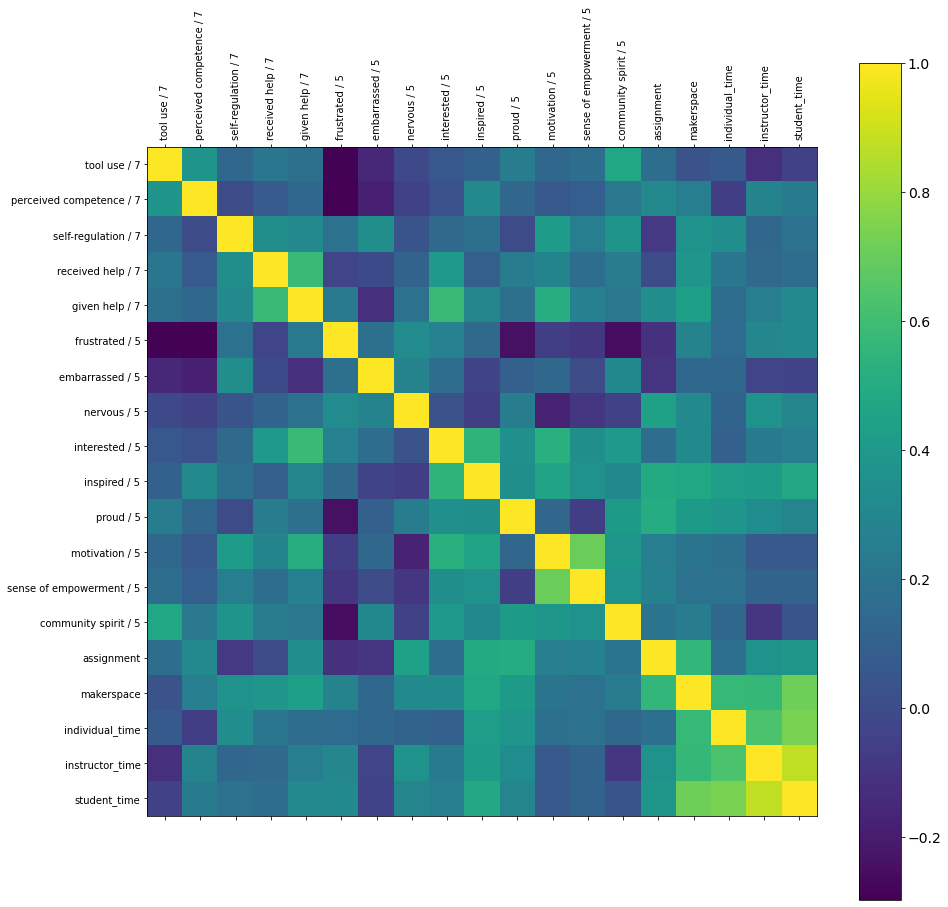

In [0]:
# Correlation Matrix
f = plt.figure(figsize=(15, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.shape[1]), corr.columns, rotation='vertical')
plt.yticks(range(corr.shape[1]), corr.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

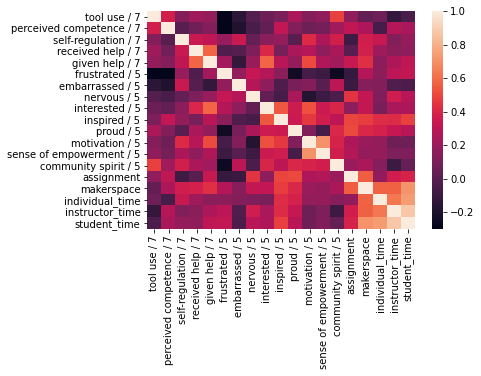

In [0]:
# Heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

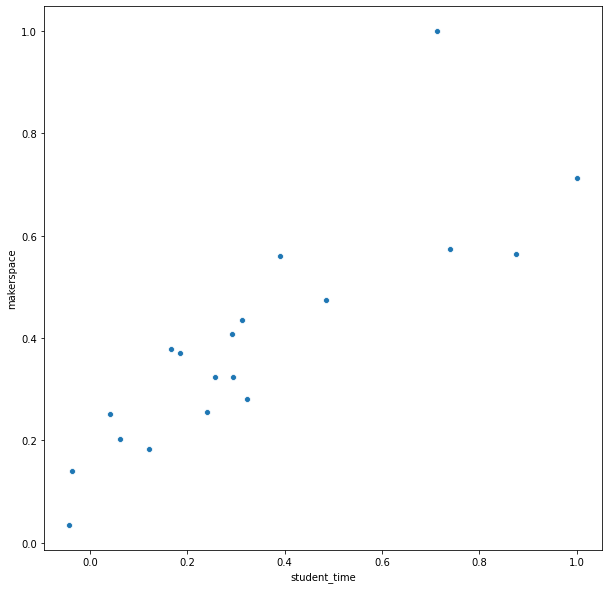

In [0]:
# Scatterplots
x = 'student_time'
y = 'makerspace'

f,ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(x=x, y=y, data=corr)
plt.xlabel(x)
plt.ylabel(y)
plt.show()